## import

In [20]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib

import torch 
from torch import distributions
from torch import nn
from torch.utils import data

## Model_Dimer

In [21]:
def ensure_traj(X):
    if np.ndim(X) == 2:
        return X
    if np.ndim(X) == 1:
        return np.array([X])
    raise ValueError('Incompatible array with shape: ', np.shape(X))

In [22]:
def distance_matrix_squared(crd1, crd2, dim=2):
    """ Returns the distance matrix or matrices between particles
    Parameters
    ----------
    crd1 : array or matrix
        first coordinate set
    crd2 : array or matrix
        second coordinate set
    dim : int
        dimension of particle system. If d=2, coordinate vectors are [x1, y1, x2, y2, ...]
    """
    crd1 = ensure_traj(crd1)
    crd2 = ensure_traj(crd2)
    n = int(np.shape(crd1)[1]/dim)

    crd1_components = [np.tile(np.expand_dims(crd1[:, i::dim], 2), (1, 1, n)) for i in range(dim)]
    crd2_components = [np.tile(np.expand_dims(crd2[:, i::dim], 2), (1, 1, n)) for i in range(dim)]
    D2_components = [(crd1_components[i] - np.transpose(crd2_components[i], axes=(0, 2, 1)))**2 for i in range(dim)]
    D2 = np.sum(D2_components, axis=0)
    return D2

In [23]:
class ParticleDimer(object):

    params_default = {
        'nsolvent' : 36,
        'eps' : 1.0,  # LJ prefactor
        'rm' : 1.1,  # LJ particle size
        #'dimer_slope' : -0.5,  # dimer slope parameter
        'dimer_slope' : 0.0,  # dimer slope parameter
        'dimer_a' : 25.0,  # dimer x2 parameter
        'dimer_b' : 10.0,  # dimer x4 parameter
        'dimer_dmid' : 1.5,  # dimer transition state distance
        'dimer_k' : 20.0,  # dimer force constant
        'box_halfsize' : 3.0,
        'box_k' : 100.0,  # box repulsion force constant
        'grid_k' : 0.0,  # restraint strength to particle grid (to avoid permutation)
        }

    def __init__(self, params=None):
        # set parameters
        if params is None:
            params = self.__class__.params_default
        self.params = params

        # useful variables
        self.nparticles = params['nsolvent'] + 2
        self.dim = 2 * self.nparticles

        # create mask matrix to help computing particle interactions
        self.mask_matrix = torch.tensor(np.ones((self.nparticles, self.nparticles), dtype=np.float32))
        self.mask_matrix[0, 1] = 0.0
        self.mask_matrix[1, 0] = 0.0
        for i in range(self.nparticles):
            self.mask_matrix[i, i] = 0.0

        # save grid to compute position restraints
        self.grid = self.init_positions(params['dimer_dmid'])


    # initialization
    def init_positions(self, dimer_distance, scaling_factor=1.05):
        """ Initializes particles positions in a box
        Parameters:
        -----------
        dimer_distance : float
            initial dimer distance
        scaling_factor : float
            scaling factor to be applied to the configuration
        """
        # dimer
        pos = []
        pos.append(np.array([-0.5*dimer_distance, 0]))
        pos.append(np.array([0.5*dimer_distance, 0]))
        # solvent particles
        sqrtn = int(np.sqrt(self.params['nsolvent']))
        locs = np.linspace(-self.params['box_halfsize']-1, self.params['box_halfsize']+1, sqrtn+2)[1:-1]
        for i in range(0, sqrtn):
            for j in range(0, sqrtn):
                pos.append(np.array([locs[i], locs[j]]))
        pos = np.array(pos).reshape((1, 2*(self.params['nsolvent']+2)))
        return scaling_factor * pos

    def draw_config(self, x, axis=None, dimercolor='blue', alpha=0.7):
        import matplotlib.pyplot as plt
        from matplotlib.patches import Rectangle, Circle

        # prepare data
        X = x.reshape(((self.params['nsolvent']+2), 2))
        # set up figure
        if axis is None:
            plt.figure(figsize=(5, 5))
            axis = plt.gca()
        #fig, ax = plt.subplots(figsize=(5, 5))
        d = self.params['box_halfsize']
        axis.set_xlim((-d, d))
        axis.set_ylim((-d, d))
        # draw box
        axis.add_patch(Rectangle((-d-self.params['rm'], -d-self.params['rm']),
                                 2*d+2*self.params['rm'], 0.5*self.params['rm'], color='lightgrey', linewidth=0))
        axis.add_patch(Rectangle((-d-self.params['rm'], d+0.5*self.params['rm']),
                                 2*d+2*self.params['rm'], 0.5*self.params['rm'], color='lightgrey', linewidth=0))
        axis.add_patch(Rectangle((-d-self.params['rm'], -d-self.params['rm']),
                                 0.5*self.params['rm'], 2*d+2*self.params['rm'], color='lightgrey', linewidth=0))
        axis.add_patch(Rectangle((d+0.5*self.params['rm'], -d-self.params['rm']),
                                 0.5*self.params['rm'], 2*d+2*self.params['rm'], color='lightgrey', linewidth=0))
        # draw solvent
        circles = []
        for x in X[2:]:
            circles.append(axis.add_patch(Circle(x, radius=0.5*self.params['rm'],
                                                 linewidth=2, edgecolor='black', facecolor='grey', alpha=alpha)))
        # draw dimer
        circles.append(axis.add_patch(Circle(X[0], radius=0.5*self.params['rm'],
                                             linewidth=2, edgecolor='black', facecolor=dimercolor, alpha=alpha)))
        circles.append(axis.add_patch(Circle(X[1], radius=0.5*self.params['rm'],
                                             linewidth=2, edgecolor='black', facecolor=dimercolor, alpha=alpha)))
        #plot(X[:, 0], X[:, 1], linewidth=0, marker='o', color='black')
        axis.set_xlim(-4, 4)
        axis.set_ylim(-4, 4)
        axis.set_xticks([])
        axis.set_yticks([])
        #return(fig, ax, circles)

    # ANIMATE
    #def animate(i):
    #    X = traj1[i].reshape(n+2, 2)
    #    for i, x in enumerate(X):
    #        circles[i].center = x
    #    return circles

    def dimer_distance(self, x):
        return np.sqrt((x[:, 2] - x[:, 0])**2 + (x[:, 3] - x[:, 1])**2)

#    def dimer_distance_tf(self, x):
#        return tf.sqrt((x[:, 2] - x[:, 0])**2 + (x[:, 3] - x[:, 1])**2)

    def dimer_distance_torch(self,x):
        return torch.sqrt((x[:, 2] - x[:, 0])**2 + (x[:, 3] - x[:, 1])**2)

    def _distance_squared_matrix(self, crd1, crd2):
        return distance_matrix_squared(crd1, crd2, dim=2)

    def LJ_energy(self, x):
        # all component-wise distances bet
        batchsize = np.shape(x)[0]
        D2 = self._distance_squared_matrix(x, x)
        mmatrix = np.tile(np.expand_dims(self.mask_matrix, 0), (batchsize, 1, 1))
        D2 = D2 + (1.0 - mmatrix)  # this is just to avoid NaNs, the inverses will be set to 0 later
        D2rel = (self.params['rm']**2) / D2
        # remove self-interactions and interactions between dimer particles
        D2rel = D2rel * mmatrix
        # energy
        E = 0.5*self.params['eps']*np.sum(D2rel**6, axis=(1, 2))  # do 1/2 because we have double-counted each interaction
        return E

    def LJ_energy_torch(self, x):
        # all component-wise distances bet
        xcomp = x[:, 0::2]
        ycomp = x[:, 1::2]
        batchsize=x.shape[0]
        n = xcomp.shape[1]
#        batchsize = torch.shape(x)[0]
#        n = torch.shape(xcomp)[1]
        Xcomp = torch.tile(torch.unsqueeze(xcomp, 2), [1, 1, n])
        Ycomp = torch.tile(torch.unsqueeze(ycomp, 2), [1, 1, n])
        Dx = Xcomp - torch.transpose(Xcomp, 1, 2)
        Dy = Ycomp - torch.transpose(Ycomp, 1, 2)
        D2 = Dx**2 + Dy**2
        mmatrix = torch.tile(torch.unsqueeze(self.mask_matrix, 0), [batchsize, 1, 1])
        D2 = D2 + (1.0 - mmatrix)  # this is just to avoid NaNs, the inverses will be set to 0 later
        D2rel = (self.params['rm']**2) / D2
        # remove self-interactions and interactions between dimer particles
        D2rel = D2rel * mmatrix
        # energy
        E = 0.5*self.params['eps']*torch.sum(D2rel**6, axis=(1, 2))  # do 1/2 because we have double-counted each interaction
        return E
    
    def dimer_energy_distance(self, d):
      d0 = 2 * (d - self.params['dimer_dmid'])
      d2 = d0*d0
      d4 = d2*d2
      energy_interaction = self.params['dimer_slope']*d0 - self.params['dimer_a']*d2 + self.params['dimer_b']*d4
      return energy_interaction
    
    def dimer_energy(self, x):
        # center restraint energy
        energy_dx = self.params['dimer_k']*(x[:, 0] + x[:, 2])**2
        # y restraint energy
        energy_dy = self.params['dimer_k']*(x[:, 1])**2 + self.params['dimer_k']*(x[:, 3])**2
        # first two particles
        d = np.sqrt((x[:, 0]-x[:, 2])**2 + (x[:, 1]-x[:, 3])**2)
        d0 = 2 * (d - self.params['dimer_dmid'])
        d2 = d0*d0
        d4 = d2*d2
        energy_interaction = self.params['dimer_slope']*d0 - self.params['dimer_a']*d2 + self.params['dimer_b']*d4

        return energy_dx + energy_dy + energy_interaction

    def dimer_energy_torch(self, x):
        # center restraint energy
        energy_dx = self.params['dimer_k']*(x[:, 0] + x[:, 2])**2
        # y restraint energy
        energy_dy = self.params['dimer_k']*(x[:, 1])**2 + self.params['dimer_k']*(x[:, 3])**2
        # first two particles
        d = torch.sqrt((x[:, 0]-x[:, 2])**2 + (x[:, 1]-x[:, 3])**2)
        d0 = 2 * (d - self.params['dimer_dmid'])
        d2 = d0*d0
        d4 = d2*d2
        energy_interaction = self.params['dimer_slope']*d0 - self.params['dimer_a']*d2 + self.params['dimer_b']*d4

        return energy_dx + energy_dy + energy_interaction

    def box_energy(self, x):
        xcomp = x[:, 0::2]
        ycomp = x[:, 1::2]
        # indicator functions
        E = 0.0
        d_left = -(xcomp + self.params['box_halfsize'])
        E += np.sum((np.sign(d_left) + 1) * self.params['box_k'] * d_left**2, axis=1)
        d_right = (xcomp - self.params['box_halfsize'])
        E += np.sum((np.sign(d_right) + 1) * self.params['box_k'] * d_right**2, axis=1)
        d_down = -(ycomp + self.params['box_halfsize'])
        E += np.sum((np.sign(d_down) + 1) * self.params['box_k'] * d_down**2, axis=1)
        d_up = (ycomp - self.params['box_halfsize'])
        E += np.sum((np.sign(d_up) + 1) * self.params['box_k'] * d_up**2, axis=1)
        return E

    def box_energy_torch(self, x):
        xcomp = x[:, 0::2]
        ycomp = x[:, 1::2]
        # indicator functions
        E = 0.0
        d_left = -(xcomp + self.params['box_halfsize'])
        E += torch.sum((torch.sign(d_left) + 1) * self.params['box_k'] * d_left**2, axis=1)
        d_right = (xcomp - self.params['box_halfsize'])
        E += torch.sum((torch.sign(d_right) + 1) * self.params['box_k'] * d_right**2, axis=1)
        d_down = -(ycomp + self.params['box_halfsize'])
        E += torch.sum((torch.sign(d_down) + 1) * self.params['box_k'] * d_down**2, axis=1)
        d_up = (ycomp - self.params['box_halfsize'])
        E += torch.sum((torch.sign(d_up) + 1) * self.params['box_k'] * d_up**2, axis=1)
        return E

    def grid_energy(self, x):
        d2 = (x - self.grid)**2
        E = np.sum(self.params['grid_k'] * (self.params['rm']**2 * d2) ** 6, axis=1)
        return E

    def grid_energy_torch(self, x):
        d2 = (x - self.grid)**2
        E = torch.sum(self.params['grid_k'] * (self.params['rm']**2 * d2) ** 6, axis=1)
        return E  

    def energy_torch(self, x):
        return self.LJ_energy_torch(x) + self.dimer_energy_torch(x) + self.box_energy_torch(x) + self.grid_energy_torch(x)

    def _energy(self, x):
        return self.LJ_energy(x) + self.dimer_energy(x) + self.box_energy(x) + self.grid_energy(x)

    def energy(self, x):
        if x.shape[0] < 10000:
            return self._energy(x)
        else:
            energy_x = np.zeros(x.shape[0])
            for i in range(0, len(energy_x), 10000):
                i_from = i
                i_to = min(i_from + 10000, len(energy_x))
                energy_x[i_from:i_to] = self._energy(x[i_from:i_to])
            return energy_x

    def plot_dimer_energy(self, axis=None):
        """ Plots the dimer energy to the standard figure """
        x_scan = np.linspace(0.5, 2.5, 100)
        E_scan = self.dimer_energy(np.array([1.5-0.5*x_scan, np.zeros(100), 1.5+0.5*x_scan, np.zeros(100)]).T)
        E_scan -= E_scan.min()

        if axis is None:
            axis = plt.gca()
        #plt.figure(figsize=(5, 4))
        axis.plot(x_scan, E_scan, linewidth=2)
        axis.set_xlabel('x / a.u.')
        axis.set_ylabel('Energy / kT')
        axis.set_ylim(E_scan.min() - 2.0, E_scan[int(E_scan.size / 2)] + 2.0)


        return x_scan, E_scan

## Model_BG

In [24]:
class BG_RealNVP(nn.Module):
  def __init__(self,target,dim,stochastic=False,step_size=0.25,nsteps=10,n_hidden=256,n_block=8,masks=None,nets=None,nett=None):
    super(BG_RealNVP,self).__init__()
    self.stochastic=stochastic
    self.step_size=step_size
    self.nsteps=nsteps
    self.target_model=target
    self.n_hidden=n_hidden
    self.n_block=n_block
    self.dim=dim

    if nets==None:
      nets = lambda: nn.Sequential(nn.Linear(self.dim, self.n_hidden), nn.ReLU(), nn.Linear(self.n_hidden, self.n_hidden), nn.ReLU(), nn.Linear(self.n_hidden, self.dim), nn.Tanh())
    if nett==None:
      nett = lambda: nn.Sequential(nn.Linear(self.dim, self.n_hidden), nn.ReLU(), nn.Linear(self.n_hidden, self.n_hidden), nn.ReLU(), nn.Linear(self.n_hidden, self.dim))

    self.prior = distributions.MultivariateNormal(torch.zeros(self.dim), torch.eye(self.dim))


    if masks==None:
      self.masks = nn.Parameter(torch.from_numpy(np.array([np.tile([0,1],int(self.dim/2)), np.tile([1,0],int(self.dim/2))] * self.n_block).astype(np.float32)), requires_grad=False)

    self.nett = torch.nn.ModuleList([nett() for _ in range(len(self.masks))]) # translation function (net)
    self.nets = torch.nn.ModuleList([nets() for _ in range(len(self.masks))]) # scaling function (net)

  def target_energy(self,x):
    return self.target_model.energy_torch(x)

  def prior_energy(self, z):
    return 0.5*torch.linalg.norm(z,dim=1)**2

  def forward_flow(self,z):

    log_R_zx, x = z.new_zeros(z.shape[0]), z

    for i in range(len(self.masks)):
      x1= x*self.masks[i]

      s=self.nets[i](x1)*(1-self.masks[i])
      t=self.nett[i](x1)*(1-self.masks[i])

      x=x1+(1-self.masks[i])* (x*torch.exp(s)+t)
      log_R_zx+=torch.sum(s,-1)
    return x, log_R_zx

  def backward_flow(self,x):
    log_R_xz, z = x.new_zeros(x.shape[0]), x

    for i in reversed(range(len(self.masks))):

      z1= z*self.masks[i]

      s=self.nets[i](z1)*(1-self.masks[i])
      t=self.nett[i](z1)*(1-self.masks[i])

      z=z1+(1-self.masks[i])*(z-t)*torch.exp(-s)
      log_R_xz-=torch.sum(s,-1)

    return z, log_R_xz

  def sample(self, batchSize):
      z = self.prior.sample((batchSize,))
#      logp = self.prior.log_prob(z)
      x, log_R_zx = self.forward_flow(z)
      return z.detach().numpy() , x.detach().numpy(), log_R_zx.detach().numpy()

  def loss(self, batch, w_ml = 1.0, w_kl = 0.0, w_rc = 0.0):
      return w_ml*self.loss_ml(batch) + w_kl*self.loss_kl(batch) + w_rc*self.loss_rc(batch)  

  def loss_ml(self, batch_x):
      z, log_R_xz = self.backward_flow(batch_x)
      energy=0.5*torch.linalg.norm(z,dim=1)**2
      return torch.mean(energy-log_R_xz)

  def loss_kl(self, batch_z):
      x, log_R_zx = self.forward_flow(batch_z)
      energy=self.target_energy(x)
      e_high=1e5
      for i in range(len(energy)):
        if abs(energy[i]) == float('inf'):
                print("energy overflow detected")
        elif energy[i] > e_high:
                energy[i] = e_high + torch.log(energy[i] - e_high + 1.0)

      return torch.mean(energy - log_R_zx)  

  def loss_mix(self, batch_x, batch_z=None, w_kl=0.5, w_ml=0.5):
      if batch_z==None:
          batch_z = self.prior.sample((batch_x.shape[0],))
      return w_kl*self.loss_kl(batch_z)+w_ml*self.loss_ml(batch_x) 
    
  def train_mix(self, x_training_set, z_training_set=None, iter=200, lr=1e-3, batch_size=1024,w_kl=0.5,w_ml=0.5):
      optimizer = torch.optim.Adam(self.parameters(), lr=lr)
      trainloader = data.DataLoader(dataset=x_training_set, batch_size=batch_size)
      losses = []
      t = 0 # iteration count
      while t < iter:
          for batch_x in trainloader:  

              # Custom ML loss function
              loss = self.loss_mix(batch_x=batch_x, w_kl=w_kl, w_ml=w_ml) 
              losses.append(loss.item()) # save values for plotting later 

              # Training
              optimizer.zero_grad() # Set grads to zero, else PyTorch will accumulate gradients on each backprop
              loss.backward(retain_graph=True)
              optimizer.step()
              t=t+1

      return losses

  def train_ML(self, training_data, iter=200, lr=1e-3, batch_size=1024):

      optimizer = torch.optim.Adam(self.parameters(), lr=lr) 
      trainloader = data.DataLoader(dataset=training_data, batch_size=batch_size)

      losses = []
      t = 0 # iteration count
      while t < iter:
          for batch in trainloader:  

              # Custom ML loss function
              loss = self.loss_ml(batch) 
              losses.append(loss.item()) # save values for plotting later 

              # Training
              optimizer.zero_grad() # Set grads to zero, else PyTorch will accumulate gradients on each backprop
              loss.backward(retain_graph=True)
              optimizer.step()
              t=t+1

      return losses

  def train_KL(self, training_data=None, training_data_size=1000, iter=200, lr=1e-3, batch_size=1024):
      if training_data==None:
          training_data=self.prior.sample((training_data_size,))
      optimizer = torch.optim.Adam(self.parameters(), lr=lr)
      trainloader = data.DataLoader(dataset=training_data, batch_size=batch_size)
      losses = []
      t = 0 # iteration count
      while t < iter:
          for batch in trainloader:  

              # Custom ML loss function
              loss = self.loss_kl(batch) 
              losses.append(loss.item()) # save values for plotting later 

              # Training
              optimizer.zero_grad() # Set grads to zero, else PyTorch will accumulate gradients on each backprop
              loss.backward(retain_graph=True)
              optimizer.step()
              t=t+1

      return losses

## Data

In [25]:
def plot_dimer_energy_with_data(model, x, axis=None):
    counts, bins = np.histogram(x, bins = 200 )
    anchors = (bins[1:] + bins[:-1]) / 2
    probs = counts / np.sum(counts)

    anchors = anchors[np.where(probs > 0.0001)]
    probs = probs[np.where(probs > 0.0001)]

    f = -np.log(probs)
    fn = f - np.min(f)
    plt.scatter(anchors, fn)  
    """ Plots the dimer energy to the standard figure """
    d_scan = np.linspace(0.5, 2.5, 100)
    E_scan = model.dimer_energy_distance(d_scan)
    E_scan -= E_scan.min()

    if axis is None:
        axis = plt.gca()
    #plt.figure(figsize=(5, 4))
    axis.plot(d_scan, E_scan, linewidth=2)
    axis.set_xlabel('x / a.u.')
    axis.set_ylabel('Energy / kT')
    axis.set_ylim(E_scan.min() - 2.0, E_scan[int(E_scan.size / 2)] + 2.0)


    return d_scan, E_scan

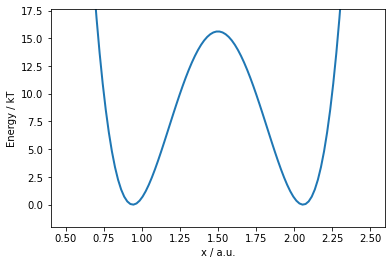

In [26]:
model_dimer=ParticleDimer()
x,e=model_dimer.plot_dimer_energy()

In [27]:
x_brute=np.load('dimer_data\dimer_data_36p.npy')
x_brute.shape

(80000, 76)

In [28]:
x_brute_d=model_dimer.dimer_distance(x_brute)

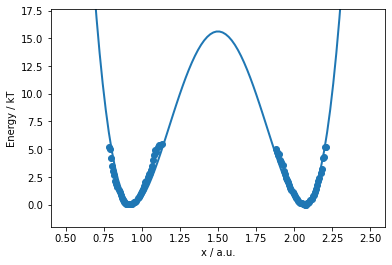

In [29]:
x,E=plot_dimer_energy_with_data(model_dimer,x_brute_d)

## train

In [30]:
model_BG=BG_RealNVP(model_dimer,dim=model_dimer.dim)

In [31]:
x_brute.shape

(80000, 76)

In [32]:
loss=model_BG.train_ML(x_brute,iter=1000,lr=1e-3,batch_size=2048)

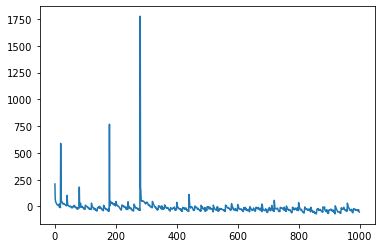

In [33]:
plt.plot(loss)

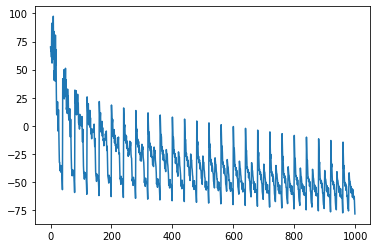

In [34]:
loss=model_BG.train_ML(x_brute,iter=1000,lr=1e-5,batch_size=2048)
plt.plot(loss)

In [35]:
z,x,dw=model_BG.sample(1000)

In [36]:
x_d=model_dimer.dimer_distance(x)

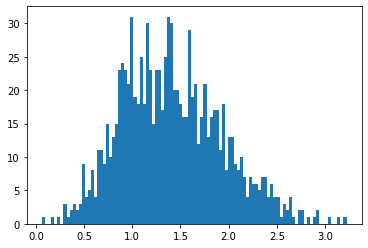

In [37]:
plt.hist(x_d,bins=100)
plt.show()

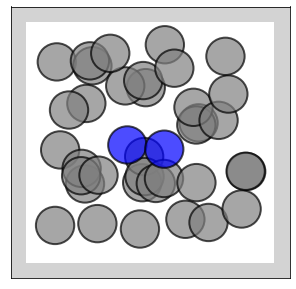

In [38]:
model_dimer.draw_config(x[-1])